In [1]:
import datajoint as dj
from ibl_pipeline import behavior, ephys
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from ibl_pipeline.plotting import plotting_utils as putils

Connecting shan@datajoint.internationalbrainlab.org:3306
Connected to https://alyx.internationalbrainlab.org as vathes
Connected to https://alyx.internationalbrainlab.org as vathes


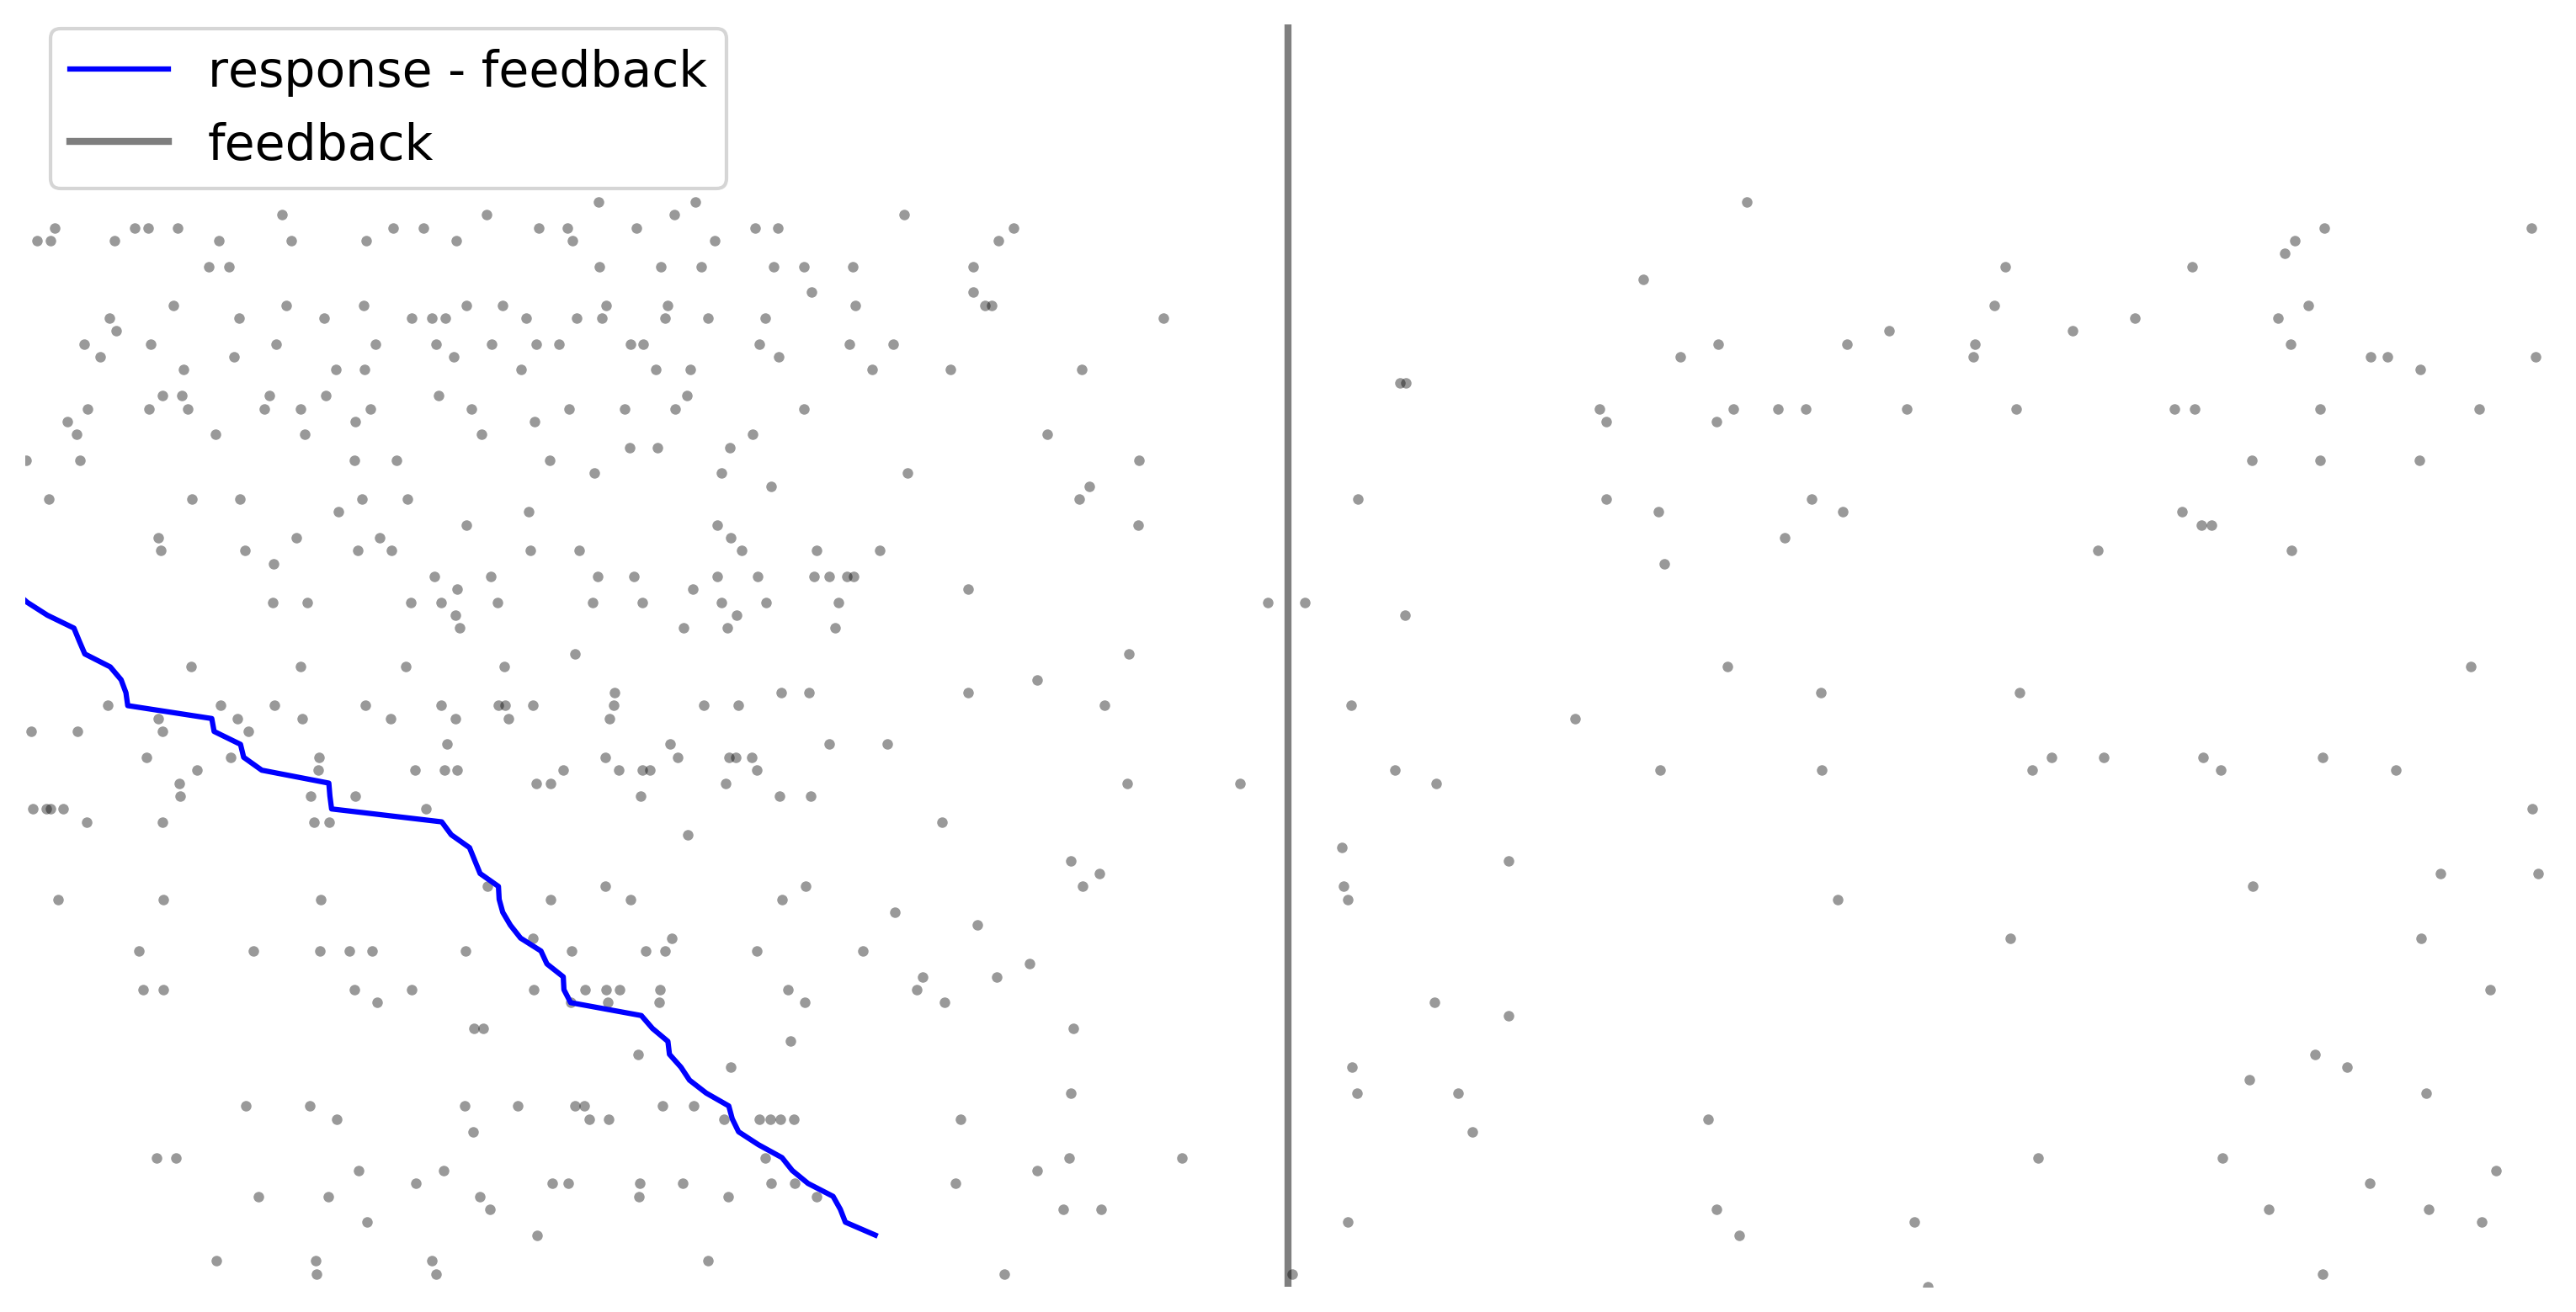

In [7]:
# Rasters aligned
cluster = ephys.Cluster & 'cluster_id=248'
trials_all = (behavior.TrialSet.Trial * ephys.TrialSpikes & cluster).proj(
    'trial_start_time', 'trial_stim_on_time', 'trial_response_time', 'trial_feedback_time',
    'trial_response_choice', 'trial_spike_times',
    trial_duration='trial_end_time-trial_start_time',
    trial_signed_contrast='trial_stim_contrast_right - trial_stim_contrast_left'
) & 'trial_duration < 5' & 'trial_response_choice!="No Go"'

trials_left = trials_all & 'trial_response_choice="CW"' & 'trial_signed_contrast < 0'
trials_right = trials_all & 'trial_response_choice="CCW"' & 'trial_signed_contrast > 0'
trials = trials_all & [trials_right.proj(), trials_left.proj()]
align_event = 'feedback'
x_lim = [-1, 1]
encoded_string, y_lim = putils.create_raster_plot(trials, align_event, 'feedback - response')

In [8]:
data = go.Scatter(
    x=x_lim,
    y=y_lim,
    mode='markers',
    marker=dict(opacity=0)
)

layout = go.Layout(
    images=[dict(
      source='data:image/png;base64, ' + encoded_string.decode(),
      sizex=x_lim[1] - x_lim[0],
      sizey=y_lim[1] - y_lim[0],
      x=x_lim[0],
      y=y_lim[1],
      xref='x',
      yref='y',
      sizing='stretch',
      layer='below'
    )],
    width=580,
    height=370,
    margin=go.layout.Margin(
        l=50,
        r=30,
        b=40,
        t=80,
        pad=0
    ),
    title=dict(
        text='Raster, aligned to {}'.format(align_event),
        y=0.87
    ),
    xaxis=dict(
        title='Time/sec',
        range=x_lim,
        showgrid=False
    ), 
    yaxis=dict(
        title='Trial idx',
        range=y_lim,
        showgrid=False
    ),
)

fig = go.Figure(data=[data], layout=layout)
plotly.offline.iplot(fig)

In [79]:
import json
f = open("rasters.json","w")
s = json.dumps(fig.to_plotly_json())
f.write(s)
f.close()